# System baseline
**Gemaakt door Jantina Schakel, Durk Betsema, Leon Wetzel en Rik Zijlema**


In dit notebook bekijken we wat een mogelijke goede baseline kan zijn. Ook wordt gekeken naar de verdeling van de *trialdata* in het kader van SemEval 2021 Task 1.

In [ ]:
import sys
import os
import csv

from collections import defaultdict
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)

In [ ]:
# IMPORT Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
WORKING_DIR = '/content/gdrive/My Drive/2020 - 2021 1 Shared Task Information Science/Assignment 2 - System baseline'

MULTI_TRIAL_FILE_NAME = "lcp_multi_trial.tsv"
SINGLE_TRIAL_FILE_NAME = "lcp_single_trial.tsv"

In [ ]:
print(f"Python version: {sys.version}")
os.chdir(WORKING_DIR)
print(f"Current working dir: {os.getcwd()}")

vowels = {'a', 'e', 'u', 'i', 'o'}

Python version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Current working dir: /content/gdrive/.shortcut-targets-by-id/1iK3ZTloYGsrShqJrSqmk2hprsg8miPqM/2020 - 2021 1 Shared Task Information Science/Assignment 2 - System baseline


# Hoe ziet de data eruit?

We zijn benieuwd naar hoe de data verdeeld is en of er grote verschillen in sentiment zitten tussen de verschillende genres.

## Voorbereidingen voor analyse

Voordat we in de data kunnen duiken, moeten we wat voorbereidingen treffen. We lezen de bestanden uit en plaatsen de data in dictionaries.

In [ ]:
multi_trial_data = pd.read_csv(f"data/{MULTI_TRIAL_FILE_NAME}", delimiter='\t',
                               header=0, names=['id', 'subcorpus', 'sentence',
                                                'token', 'complexity'], 
                               quoting=csv.QUOTE_NONE, encoding='utf-8')

single_trial_data = pd.read_csv(f"data/{SINGLE_TRIAL_FILE_NAME}", delimiter='\t',
                               header=0, names=['id', 'subcorpus', 'sentence',
                                                'token', 'complexity'], 
                               quoting=csv.QUOTE_NONE, encoding='utf-8')

In [ ]:
#Print lengte en voorbeeld single trail data
print(len(single_trial_data))
print(single_trial_data.head()) 

421
                               id subcorpus  ... token complexity
0  3QI9WAYOGQB8GQIR4MDIEF0D2RLS67     bible  ...   sea   0.000000
1  3T8DUCXY0N6WD9X4RTLK8UN1U929TF     bible  ...   sea   0.102941
2  3I7KR83SNADXAQ7HXK7S7305BYB9KD     bible  ...   sea   0.109375
3  3BO3NEOQM0HK9ERYPN0GQIWCPC4IAQ     bible  ...   sea   0.160714
4  3Y3CZJSZ9KT0W7I0KE38WZHHKSW5RH     bible  ...  land   0.000000

[5 rows x 5 columns]


In [ ]:
#Print lengte en voorbeeld multi trail data
print(len(multi_trial_data))
print(multi_trial_data.head())

99
                               id subcorpus  ...          token complexity
0  31HLTCK4BLVQ5BO1AUR91TX9V9IVGH     bible  ...   foreign land   0.000000
1  389A2A304OIXVY7G5B71Q9M43LE0CL     bible  ...    wheat flour   0.157895
2  31N9JPQXIPIRX2A3S9N0CCFXO6TNHR     bible  ...  burnt incense   0.200000
3  3JVP4ZJHDPSO81TGXL3N1CKZGQY0IN     bible  ...  burnt incense   0.250000
4  3JAOYN9IHL25ZQAUV5EJZ4GH0KL33L     bible  ...   bronze altar   0.214286

[5 rows x 5 columns]


In [ ]:
def df_to_dict(dataframe):
    """
    Transforms a given dataframe into a Python dictionary.
    :returns: two-dimensional dictionary with subcorpus
              and sentence ID as keys, and a dictionary
              containing sentence, token and complexity
              as value
    """
    sentences = defaultdict(dict)
    for index, row in dataframe.iterrows():
        sentences[row['subcorpus']][row['id']] = {
            'sentence': row['sentence'], 'token': row['token'],
            'complexity': row['complexity']}
    return sentences


def get_sentence_lengths(dataset):
    """
    Extracts gross and net lengths of sentences per subcorpus.
    :returns: 
    """
    net_sentence_lengths, gross_sentence_lengths = {}, {}
    for subcorpus, value in dataset.items():
        gross_lengths, net_lengths = [], []
        for i, row in value.items():
            gross_lengths.append(len(row['sentence']))
            net_lengths.append(len(row['sentence'].replace(" ", "")))

        gross_sentence_lengths[subcorpus] = gross_lengths
        net_sentence_lengths[subcorpus] = net_lengths
    
    return net_sentence_lengths, gross_sentence_lengths

## Multi trial data

Multi trial data hoort bij de subtaak waar meerdere tokens van toepassing zijn.

In [ ]:
mtd = df_to_dict(multi_trial_data)
mtd_net_lengths, mtd_gross_lengths = get_sentence_lengths(mtd)
labels = mtd_gross_lengths.keys() # get labels for visualisation

for subcorpus, lengths in mtd_net_lengths.items():
    print(subcorpus, sum(lengths) / len(lengths))
# print(mtd_gross_lengths)

bible 101.6896551724138
biomed 168.8181818181818
europarl 176.86486486486487


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


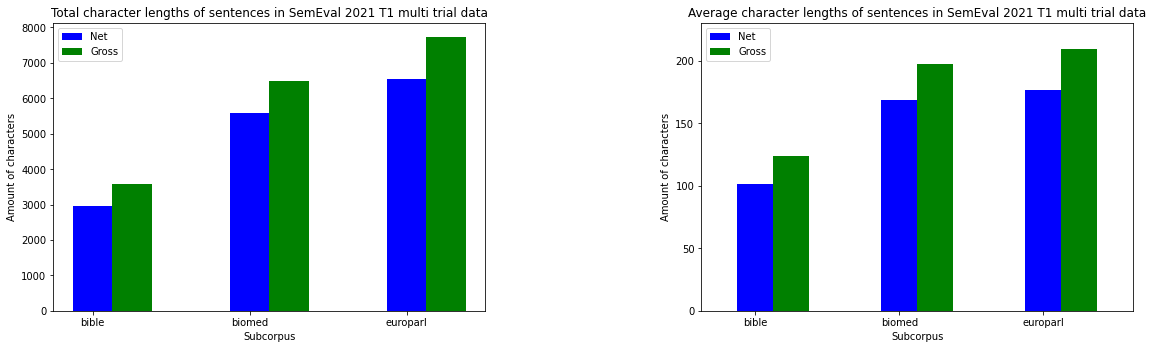

In [ ]:
net_sums = [sum(x) for x in mtd_net_lengths.values()]
gross_sums = [sum(x) for x in mtd_gross_lengths.values()]

net_means = [sum(x)/len(x) for x in mtd_net_lengths.values()]
gross_means = [sum(x)/len(x) for x in mtd_gross_lengths.values()]

fig, (ax1, ax2) = plt.subplots(1, 2)
X = np.arange(len(labels))

ax1 = fig.add_axes([0, 0, 1, 1])
ax1.bar(X, net_sums, color = 'b', width = 0.25, label='Net')
ax1.bar(X + 0.25, gross_sums, color = 'g', width = 0.25, label="Gross")

ax1.set_xlabel('Subcorpus')
ax1.set_ylabel('Amount of characters')
ax1.set_title('Total character lengths of sentences in SemEval 2021 T1 multi trial data')
ax1.set_xticks(X)
ax1.set_xticklabels(labels)
ax1.legend()
ax1.plot()

ax2 = fig.add_axes([1.5, 0, 1, 1])
ax2.bar(X, net_means, color = 'b', width = 0.25, label='Net')
ax2.bar(X + 0.25, gross_means, color = 'g', width = 0.25, label="Gross")
ax2.margins(0.1, 0.1)

ax2.set_xlabel('Subcorpus')
ax2.set_ylabel('Amount of characters')
ax2.set_title('Average character lengths of sentences in SemEval 2021 T1 multi trial data')
ax2.set_xticks(X)
ax2.set_xticklabels(labels)
ax2.legend()
ax2.plot()

fig.tight_layout()
plt.show()

We kunnen observeren dat teksten uit **bible** gemiddeld genomen de kortste zinnen hebben ($\overline{SL}_{bible}=12$, gevolgd door **biomed** 

In [ ]:
# Add column with likert scale
def likert_scale(value):
    if value < 0.25:
        return 1
    elif value >= 0.25 and value < 0.5:
        return 2
    elif value >= 0.5 and value < 0.75:
        return 3
    elif value >= 0.75 and value < 1:
        return 4
    else:
        return 5

multi_trial_data["likert"] = multi_trial_data["complexity"].apply(likert_scale)
multi_trial_data["likert"].value_counts().sort_index()

1    11
2    58
3    28
4     2
Name: likert, dtype: int64

In [ ]:
# Checking
print(multi_trial_data[multi_trial_data["complexity"] < 0.25].shape[0])
print(multi_trial_data[(multi_trial_data["complexity"] >= 0.25) & (multi_trial_data["complexity"] < 0.5)].shape[0])
print(multi_trial_data[(single_trial_data["complexity"] >= 0.5) & (multi_trial_data["complexity"] < 0.75)].shape[0])
print(multi_trial_data[(multi_trial_data["complexity"] >= 0.75) & (multi_trial_data["complexity"] <= 1)].shape[0])

11
58
0
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [ ]:
#Sentence
multi_trial_data["sentence_length"] = multi_trial_data["sentence"].str.len()
multi_trial_data["s_word_count"] = multi_trial_data["sentence"].str.split().str.len()
multi_trial_data["s_avg_word_length"] = round(multi_trial_data["sentence_length"] / multi_trial_data["s_word_count"]).astype(int)
multi_trial_data["s_vowel_count"] = multi_trial_data["sentence"].str.lower().str.count(r'[aeiou]')


#Token
multi_trial_data["t_length"] = multi_trial_data["token"].str.len()
multi_trial_data["t_vowel_count"] = multi_trial_data["token"].str.lower().str.count(r'[aeiou]')
multi_trial_data.head()

,id,subcorpus,sentence,token,complexity,likert,sentence_length,s_word_count,s_avg_word_length,s_vowel_count,t_length,t_vowel_count
0,31HLTCK4BLVQ5BO1AUR91TX9V9IVGH,bible,"The name of one son was Gershom, for Moses sai...",foreign land,0.000000,1,97,20,5,32,12,4
1,389A2A304OIXVY7G5B71Q9M43LE0CL,bible,"unleavened bread, unleavened cakes mixed with ...",wheat flour,0.157895,1,132,21,6,47,11,4
2,31N9JPQXIPIRX2A3S9N0CCFXO6TNHR,bible,However the high places were not taken away; t...,burnt incense,0.200000,1,110,19,6,33,13,4
3,3JVP4ZJHDPSO81TGXL3N1CKZGQY0IN,bible,"and he burnt incense of sweet spices on it, as...",burnt incense,0.250000,2,70,13,5,21,13,4
4,3JAOYN9IHL25ZQAUV5EJZ4GH0KL33L,bible,The same day the king made the middle of the c...,bronze altar,0.214286,1,345,64,5,107,12,4


In [ ]:
multi_trial_data.corr(method="pearson")

,complexity,likert,sentence_length,s_word_count,s_avg_word_length,s_vowel_count,t_length,t_vowel_count
complexity,1.000000,0.889350,0.082057,0.015194,0.291902,0.072256,0.482236,0.454082
likert,0.889350,1.000000,0.028910,-0.033182,0.230288,0.012060,0.421145,0.363757
sentence_length,0.082057,0.028910,1.000000,0.974917,0.319007,0.990793,0.378475,0.415989
s_word_count,0.015194,-0.033182,0.974917,1.000000,0.143276,0.960861,0.273230,0.323457
s_avg_word_length,0.291902,0.230288,0.319007,0.143276,1.000000,0.347668,0.532112,0.532294
s_vowel_count,0.072256,0.012060,0.990793,0.960861,0.347668,1.000000,0.376938,0.443260
t_length,0.482236,0.421145,0.378475,0.273230,0.532112,0.376938,1.000000,0.867517
t_vowel_count,0.454082,0.363757,0.415989,0.323457,0.532294,0.443260,0.867517,1.000000


Zwakke positieve correlatie tussen complexity en gemiddelde woordlengte per zin,  zwakke/gemiddelde positieve correlatie tussen complexity en token lengte en complexity en hoeveelheid klinkers in token.

In [ ]:
le = preprocessing.LabelEncoder()
multi_trial_data["subcorpus"] = le.fit_transform(multi_trial_data["subcorpus"])

In [ ]:
#Try out linear reg model on all features of the multi trail and predict complexity 
pd_x = multi_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
pd_y = multi_trial_data['complexity']

reg_model = linear_model.LinearRegression()

train_x, test_x, train_y, test_y = train_test_split(pd_x, pd_y, test_size=0.2, random_state=3)

reg_model.fit(train_x, train_y)

reg_model.coef_

pred_y = reg_model.predict(test_x)

mean_squared_error(test_y, pred_y)

0.012787187278166212

In [ ]:
#Try out linear reg model on all features of the multi trail and predict likert 
pd_x = multi_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
pd_y = multi_trial_data['likert']

reg_model = linear_model.LinearRegression()

train_x, test_x, train_y, test_y = train_test_split(pd_x, pd_y, test_size=0.2, random_state=3)

reg_model.fit(train_x, train_y)

reg_model.coef_

pred_y = reg_model.predict(test_x)
pred_y = pred_y.round(0) #wel of niet afronden? 
mean_squared_error(test_y, pred_y)

0.65

In [ ]:
#Try linear svm on all features of multi trial and predict likert
X = multi_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
y = multi_trial_data['likert']
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
scores = []
best_svm = svm.LinearSVC()
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    best_svm.fit(X_train, y_train)
    scores.append(best_svm.score(X_test, y_test))
print(sum(scores) / len(scores))


0.5233333333333333


In [ ]:
#Try multinomial NB
X = multi_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
y = multi_trial_data['likert']
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
clf = MultinomialNB()
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print(sum(scores) / len(scores))

0.5527777777777777


## Single trial data

In [ ]:
std = df_to_dict(single_trial_data)
std_net_lengths, std_gross_lengths = get_sentence_lengths(std)
labels = std_gross_lengths.keys()

print(std_net_lengths)
print(std_gross_lengths)

{'bible': [112, 219, 60, 89, 126, 96, 40, 145, 28, 145, 52, 127, 91, 177, 49, 144, 102, 109, 36, 103, 29, 115, 99, 193, 212, 137, 248, 86, 128, 189, 37, 103, 76, 73, 84, 176, 221, 110, 34, 39, 64, 92, 147, 141, 135, 158, 72, 75, 265, 123, 123, 150, 226, 126, 107, 142, 25, 235, 244, 129, 86, 61, 66, 33, 27, 126, 144, 111, 26, 173, 204, 99, 71, 122, 73, 88, 170, 90, 149, 60, 144, 78, 83, 35, 55, 152, 46, 35, 71, 75, 105, 87, 134, 73, 181, 72, 65, 92, 119, 76, 75, 190, 124, 82, 79, 46, 61, 55, 177, 107, 75, 138, 133, 127, 199, 145, 69, 71, 129, 82, 100, 207, 66, 116, 173, 153, 26, 108, 88, 78, 42, 102, 161, 45, 106, 49, 123, 187, 60, 68, 210, 77, 53], 'biomed': [106, 117, 103, 122, 105, 226, 157, 164, 195, 124, 140, 110, 237, 146, 140, 212, 124, 93, 107, 228, 60, 133, 189, 76, 115, 164, 244, 340, 124, 66, 126, 138, 319, 121, 112, 103, 310, 238, 171, 181, 59, 271, 105, 307, 132, 89, 105, 120, 144, 206, 153, 147, 178, 114, 195, 348, 250, 296, 244, 69, 147, 170, 157, 214, 268, 146, 142, 166,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


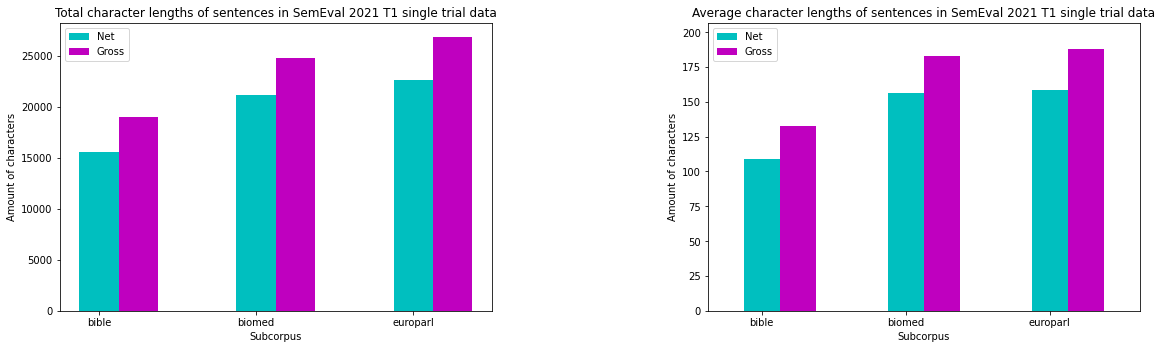

In [ ]:
net_sums = [sum(x) for x in std_net_lengths.values()]
gross_sums = [sum(x) for x in std_gross_lengths.values()]

net_means = [sum(x)/len(x) for x in std_net_lengths.values()]
gross_means = [sum(x)/len(x) for x in std_gross_lengths.values()]

fig, (ax1, ax2) = plt.subplots(1, 2)
X = np.arange(len(labels))

ax1 = fig.add_axes([0, 0, 1, 1])
ax1.bar(X, net_sums, color = 'c', width = 0.25, label='Net')
ax1.bar(X + 0.25, gross_sums, color = 'm', width = 0.25, label="Gross")

ax1.set_xlabel('Subcorpus')
ax1.set_ylabel('Amount of characters')
ax1.set_title('Total character lengths of sentences in SemEval 2021 T1 single trial data')
ax1.set_xticks(X)
ax1.set_xticklabels(labels)
ax1.legend()
ax1.plot()

ax2 = fig.add_axes([1.5, 0, 1, 1])
ax2.bar(X, net_means, color = 'c', width = 0.25, label='Net')
ax2.bar(X + 0.25, gross_means, color = 'm', width = 0.25, label="Gross")
ax2.margins(0.1, 0.1)

ax2.set_xlabel('Subcorpus')
ax2.set_ylabel('Amount of characters')
ax2.set_title('Average character lengths of sentences in SemEval 2021 T1 single trial data')
ax2.set_xticks(X)
ax2.set_xticklabels(labels)
ax2.legend()
ax2.plot()

fig.tight_layout()
plt.show()

In [ ]:
single_trial_data["subcorpus"].value_counts()

bible       143
europarl    143
biomed      135
Name: subcorpus, dtype: int64

In [ ]:
single_trial_data["likert"] = single_trial_data["complexity"].apply(likert_scale)
single_trial_data["likert"].value_counts().sort_index()


1    160
2    220
3     38
4      3
Name: likert, dtype: int64

In [ ]:
# Checking
print(single_trial_data[single_trial_data["complexity"] < 0.25].shape[0])
print(single_trial_data[(single_trial_data["complexity"] >= 0.25) & (single_trial_data["complexity"] < 0.5)].shape[0])
print(single_trial_data[(single_trial_data["complexity"] >= 0.5) & (single_trial_data["complexity"] < 0.75)].shape[0])
print(single_trial_data[(single_trial_data["complexity"] >= 0.75) & (single_trial_data["complexity"] <= 1)].shape[0])

160
220
38
3


In [ ]:
#Sentence
single_trial_data["sentence_length"] = single_trial_data["sentence"].str.len()
single_trial_data["s_word_count"] = single_trial_data["sentence"].str.split().str.len()
single_trial_data["s_avg_word_length"] = round(single_trial_data["sentence_length"] / single_trial_data["s_word_count"]).astype(int)
single_trial_data["s_vowel_count"] = single_trial_data["sentence"].str.lower().str.count(r'[aeiou]')


#Token
single_trial_data["t_length"] = single_trial_data["token"].str.len()
single_trial_data["t_vowel_count"] = single_trial_data["token"].str.lower().str.count(r'[aeiou]')
single_trial_data.head()

,id,subcorpus,sentence,token,complexity,likert,sentence_length,s_word_count,s_avg_word_length,s_vowel_count,t_length,t_vowel_count
0,3QI9WAYOGQB8GQIR4MDIEF0D2RLS67,bible,They will not hurt nor destroy in all my holy ...,sea,0.000000,1,139,28,5,38,3,2
1,3T8DUCXY0N6WD9X4RTLK8UN1U929TF,bible,"that sends ambassadors by the sea, even in ves...",sea,0.102941,1,264,46,6,80,3,2
2,3I7KR83SNADXAQ7HXK7S7305BYB9KD,bible,"and they entered into the boat, and were going...",sea,0.109375,1,73,14,5,25,3,2
3,3BO3NEOQM0HK9ERYPN0GQIWCPC4IAQ,bible,"Joseph laid up grain as the sand of the sea, v...",sea,0.160714,1,109,21,5,32,3,2
4,3Y3CZJSZ9KT0W7I0KE38WZHHKSW5RH,bible,There will be a highway for the remnant that i...,land,0.000000,1,159,34,5,47,4,1


In [ ]:
single_trial_data.corr(method="pearson")

,complexity,likert,sentence_length,s_word_count,s_avg_word_length,s_vowel_count,t_length,t_vowel_count
complexity,1.000000,0.871291,0.046533,-0.013009,0.237467,0.050830,0.158950,0.220490
likert,0.871291,1.000000,0.046709,-0.007867,0.211369,0.051339,0.169852,0.192755
sentence_length,0.046533,0.046709,1.000000,0.969650,0.166801,0.989930,0.106650,0.125835
s_word_count,-0.013009,-0.007867,0.969650,1.000000,-0.029053,0.955348,0.031945,0.053323
s_avg_word_length,0.237467,0.211369,0.166801,-0.029053,1.000000,0.187309,0.306240,0.287880
s_vowel_count,0.050830,0.051339,0.989930,0.955348,0.187309,1.000000,0.127968,0.163527
t_length,0.158950,0.169852,0.106650,0.031945,0.306240,0.127968,1.000000,0.826178
t_vowel_count,0.220490,0.192755,0.125835,0.053323,0.287880,0.163527,0.826178,1.000000


Zwakke positieve correlatie tussen complexity en gemiddelde woord lengte in een zin en tussen complexity en de hoeveelheid klinkers in een woord.

Erg zwakke positieve correlatie tussen complexity en woordlengte.

In [ ]:
#Convert string values to numerical for classification
le = preprocessing.LabelEncoder()
single_trial_data["subcorpus"] = le.fit_transform(single_trial_data["subcorpus"])
single_trial_data.head()

,id,subcorpus,sentence,token,complexity,likert,sentence_length,s_word_count,s_avg_word_length,s_vowel_count,t_length,t_vowel_count
0,3QI9WAYOGQB8GQIR4MDIEF0D2RLS67,0,They will not hurt nor destroy in all my holy ...,sea,0.000000,1,139,28,5,38,3,2
1,3T8DUCXY0N6WD9X4RTLK8UN1U929TF,0,"that sends ambassadors by the sea, even in ves...",sea,0.102941,1,264,46,6,80,3,2
2,3I7KR83SNADXAQ7HXK7S7305BYB9KD,0,"and they entered into the boat, and were going...",sea,0.109375,1,73,14,5,25,3,2
3,3BO3NEOQM0HK9ERYPN0GQIWCPC4IAQ,0,"Joseph laid up grain as the sand of the sea, v...",sea,0.160714,1,109,21,5,32,3,2
4,3Y3CZJSZ9KT0W7I0KE38WZHHKSW5RH,0,There will be a highway for the remnant that i...,land,0.000000,1,159,34,5,47,4,1


In [ ]:
single_trial_data.describe()

,subcorpus,complexity,likert,sentence_length,s_word_count,s_avg_word_length,s_vowel_count,t_length,t_vowel_count
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,1.000000,0.298631,1.724466,167.684086,27.812352,6.054632,51.662708,7.349169,2.814727
std,0.825198,0.137619,0.651076,92.412854,14.765966,0.836295,28.982018,2.723650,1.337685
min,0.000000,0.000000,1.000000,19.000000,3.000000,4.000000,4.000000,2.000000,0.000000
25%,0.000000,0.214286,1.000000,102.000000,17.000000,5.000000,31.000000,5.000000,2.000000
50%,1.000000,0.266667,2.000000,155.000000,26.000000,6.000000,47.000000,7.000000,2.000000
75%,2.000000,0.359375,2.000000,210.000000,35.000000,7.000000,64.000000,9.000000,4.000000
max,2.000000,0.875000,4.000000,572.000000,80.000000,10.000000,169.000000,13.000000,7.000000


In [ ]:
#Try out linear reg model on all features of the single trail and predict complexity 
pd_x = single_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
pd_y = single_trial_data['complexity']

reg_model = linear_model.LinearRegression()

train_x, test_x, train_y, test_y = train_test_split(pd_x, pd_y, test_size=0.2, random_state=3)

reg_model.fit(train_x, train_y)

reg_model.coef_

pred_y = reg_model.predict(test_x)

mean_squared_error(test_y, pred_y)







0.01767397104591199

In [ ]:
#Try out linear reg model on all features of the single trail and predict likert 
pd_x = single_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
pd_y = single_trial_data['likert']

reg_model = linear_model.LinearRegression()

train_x, test_x, train_y, test_y = train_test_split(pd_x, pd_y, test_size=0.2, random_state=3)

reg_model.fit(train_x, train_y)

reg_model.coef_

pred_y = reg_model.predict(test_x)
pred_y = pred_y.round(0) #wel of niet afronden? 
mean_squared_error(test_y, pred_y)


0.5058823529411764

In [ ]:
#Try linear svm on all features of single trial and predict likert
X = single_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
y = single_trial_data['likert']
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
scores = []
best_svm = svm.LinearSVC()
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    best_svm.fit(X_train, y_train)
    scores.append(best_svm.score(X_test, y_test))
print(sum(scores) / len(scores))

0.4653377630121816


In [ ]:
#Try multinomial NB
X = single_trial_data[['sentence_length', 's_word_count', 's_avg_word_length', 's_vowel_count', 't_length', 't_vowel_count']]
y = single_trial_data['likert']
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
clf = MultinomialNB()
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print(sum(scores) / len(scores))


0.4907253599114065


In [ ]:
pred_y

array([2., 2., 1., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.])